In [6]:
!pip install --upgrade twisted
!pip install transformers==3.0.2

/bin/bash: pip: command not found
/bin/bash: pip: command not found


In [4]:
!python -m spacy download en_core_web_md

/usr/bin/python: No module named spacy


In [5]:
!pip install ipywidgets --user

/bin/bash: pip: command not found


In [ ]:
restart

In [1]:
# Required imports
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

import random
import re
import utils
import os.path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from sklearn.feature_extraction.text import CountVectorizer
from newsqa import NewsQaExample, NewsQaModel, create_dataset, getprediction

from transformers import BertTokenizer, BertForQuestionAnswering
from transformers import DistilBertTokenizer, DistilBertForQuestionAnswering

import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)


from sklearn.metrics.pairwise import cosine_similarity
import spacy

from spacy.lang.en import English
import en_core_web_md
nlp = en_core_web_md.load()
en = English()

## EDA

In [2]:
# Reading in the dataset
data = pd.read_csv('../data/newsqa-data-v1.csv')

# Getting a sample from the dataset
data = data.sample(frac = 0.20, random_state = 9)
data = data.reset_index(drop = True)

data.head()

,story_id,question,answer_char_ranges,is_answer_absent,is_question_bad,validated_answers
0,./cnn/stories/43a488c2d73b4f34122fc92c8df04670...,When was the plane crash?,"2794:2805,372:382|398:410|372:382",0.0,0.0,"{""none"": 2}"
1,./cnn/stories/91607b09ab00b8dff5d7b98387ed132a...,Where has Musharraf lived in exile?,1018:1035|1008:1035|1018:1035,0.0,0.0,NaN
2,./cnn/stories/c674fdceb339915df2a9de1a0bd3007c...,What is he leaving?,529:543|None|237:252,0.0,0.333333333333,"{""237:252"": 2}"
3,./cnn/stories/a0c2d26c2ebecd53dcecc9ea04ae8c5a...,What should the president understand?,None|4317:4469,0.5,0.5,"{""4317:4469"": 2}"
4,./cnn/stories/ad2af6c1362a3f84000edd71fd752ad6...,Bush commutes whose sentence?,"103:129,366:380,384:397,92:103|None",0.0,0.5,"{""103:129"": 2, ""366:380"": 1}"


In [3]:
# Size of the dataset
len(data)

23927

In [4]:
# Convert to numeric and remove non-numeric rows
data = data[pd.to_numeric(data['is_question_bad'], errors = 'coerce').notnull()]
data['is_question_bad'] = data['is_question_bad'].astype(float)

# Number of bad questions
len(data[data['is_question_bad'] > 0])

4014

In [5]:
# Remove all bad questions/questions that don't make any sense
data = data[data['is_question_bad'] == 0]
data = data.reset_index(drop = True)

In [6]:
# Final data size
len(data)

17546

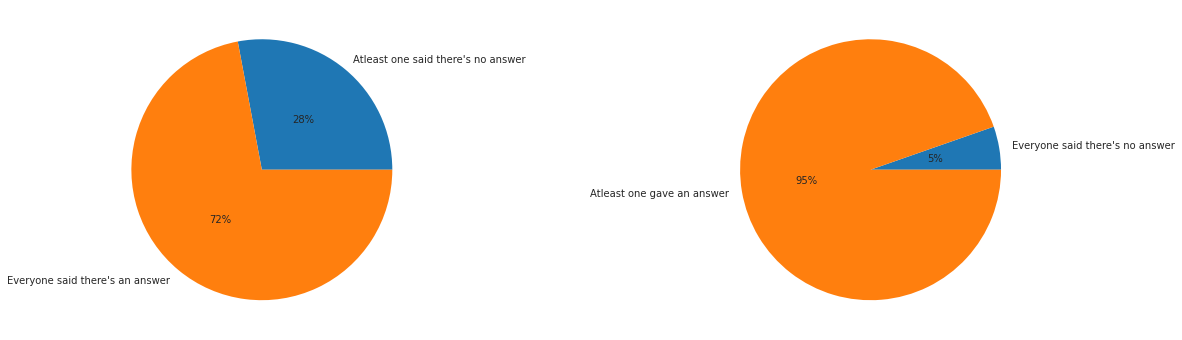

In [7]:
# Answer statistics
fig, ax = plt.subplots(ncols = 2, figsize = (20, 6))

atleast_one_no_ans = len(data[data['is_answer_absent'] != 0])
sizes1 = [atleast_one_no_ans, len(data) - atleast_one_no_ans]
labels1 = ['Atleast one said there\'s no answer', 'Everyone said there\'s an answer']
ax[0].pie(sizes1, labels = labels1, autopct = '%1.0f%%', pctdistance = 0.5, labeldistance = 1.1)

all_no_ans = len(data[data['is_answer_absent'] == 1])
sizes2 = [all_no_ans, len(data) - all_no_ans]
labels2 = ['Everyone said there\'s no answer', 'Atleast one gave an answer']
ax[1].pie(sizes2, labels = labels2, autopct = '%1.0f%%', pctdistance = 0.5, labeldistance = 1.1)

plt.show()

In [8]:
# Precentage of questions that have validated answers
100*data['validated_answers'].isnull().sum()/len(data)

55.95577339564573

In [9]:
# Word counts in questions
cv = CountVectorizer(stop_words = ['the', 'is', 'was', 'of', 'to', 'in'])
dtm = cv.fit_transform(data['question']).toarray()

word_counts = dtm.sum(axis = 0)

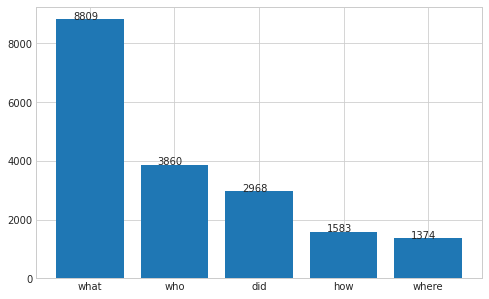

In [10]:
# Plotting top 5 words
fig, ax = plt.subplots(figsize = (8, 5))

sorted_idx = np.argsort(word_counts)[::-1]
vocab = np.array(cv.get_feature_names())

top_words_idx = sorted_idx[:5]
plt.bar(x = vocab[top_words_idx], height = word_counts[top_words_idx])

for i in range(len(top_words_idx)):
    plt.text(x = i - 0.2, y = word_counts[top_words_idx[i]] + 3, s = word_counts[top_words_idx[i]])

plt.show()

In [11]:
# Removing the path and keeping just the file name in story_id
data['story_id'] = data['story_id'].apply(lambda x: x.split('/')[-1].split('.')[0])

## Data Cleaning

In [12]:
# We don't need is_answer_absent and is_question_bad columns
data = data.drop(['is_answer_absent', 'is_question_bad'], axis = 1)

In [13]:
# Reading stories
NEWS_STORIES = utils.open_pickle('../data/news_stories.pkl')

In [14]:
def adjust_answer_range(story_id, answer_range):

    # If answer is not available, denote it as -1
    if answer_range == 'None':
        return [-1, -1]
    
    story = NEWS_STORIES[story_id]
    
    # Check for errors in answer
    if len(answer_range.split(':')) == 1:
        return [-1, -1]
    
    start_idx, end_idx = answer_range.split(':')
    start_idx, end_idx = int(start_idx), int(end_idx)
    
    # Moves back start_idx to the start of a word
    while start_idx != 0 and not utils.is_whitespace(story[start_idx - 1]) and not utils.is_punct(story[start_idx - 1]):
        start_idx = start_idx - 1
    
    # Some ranges end with a punctuation or a whitespace
    if utils.is_whitespace(story[end_idx - 1]) or utils.is_punct(story[end_idx - 1]):
        end_idx = end_idx - 1
    
    # Moves end_idx to the end of a word
    while not utils.is_whitespace(story[end_idx]) and not utils.is_punct(story[end_idx + 1]):
        end_idx = end_idx + 1
        
    # There are some answers with \n at the end followed by a letter
    # The answer will not be in two different paragraphs
    answer_text = story[start_idx:end_idx]
    answer_para = re.split('\n', answer_text)
    
    if len(answer_para[-1]) > len(answer_para[0]):
        start_idx = end_idx - len(answer_para[-1])
        answer_text = answer_para[-1]
    else:
        end_idx = start_idx + len(answer_para[0])
        answer_text = answer_para[0]
    
    return [start_idx, end_idx]

In [15]:
def get_answer(qa_details):

    # If validated answers are available, select the one with most votes
    if qa_details['validated_answers'] is not np.nan:
        validated_answers = eval(qa_details['validated_answers'])
        
        # Get the answers with maximum votes
        max_vote_ans = utils.get_max_keys(validated_answers)
        
        # Check for ties
        if len(max_vote_ans) == 1:
            return adjust_answer_range(qa_details['story_id'], max_vote_ans[0])
    
    # If validated answers are not available or if there is a tie in validated answers
    # Get all available answers
    answers = re.split(',|\|', qa_details['answer_char_ranges'])
    
    # If there is just one answer
    if len(answers) == 1:
        return adjust_answer_range(qa_details['story_id'], answers[0])
    
    # Get counts of each answer
    answer_freq = utils.get_frequency(answers)
    max_vote_ans = utils.get_max_keys(answer_freq)
    
    if len(max_vote_ans) == 1:
        return adjust_answer_range(qa_details['story_id'], max_vote_ans[0])
    
    # If there is a tie for multiple answers, return a random answer
    return adjust_answer_range(qa_details['story_id'], random.choice(answers))

In [16]:
# Select one answer range among multiple answers
data[['start_idx', 'end_idx']] = data.apply(get_answer, axis = 1, result_type = 'expand')

In [17]:
data.sample(n = 5)

,story_id,question,answer_char_ranges,validated_answers,start_idx,end_idx
9173,82b7ee7b2e3f721b26cf61dac7821000f784ef5d,Will Bush's policies stand?,"469:486,495:513,519:548|495:513,519:538|469:48...",NaN,491,514
6421,aa5421e54f99497916aaf74801f3c1d309600000,Clarkson's voice is made for what kind of songs?,1616:1625|1616:1625,NaN,1613,1629
6325,d78e32117e1617dc8a6361fe3492d87cad75fbbc,What is the name of the movement?,76:95|1865:1888|238:242,"{""76:95"": 1, ""1865:1888"": 2}",1864,1889
1719,b1e12b5e79ddcd893c69e4bd32a560c6a5dd59ef,Where will a Monday event take place?,813:825|813:825,NaN,811,825
2536,38faba9f673aa5dde55760e0c77d1b347885ae54,When did the Brazil royal family begin?,622:628|None|None,NaN,-1,-1


In [18]:
# Total examples in the dataset
total_examples = len(data)

In [37]:
pred_start,pred_end

(374, 454)

In [43]:
pred_start,pred_end

(1918, 2000)

## BERT model

In [43]:
def get_examples():
    '''
    Return a list of NewsQaExample objects
    '''
    # If a pickle file exists for examples, read the file
    if os.path.isfile('../data/examples_sample.pkl'):
        return utils.open_pickle('../data/examples_sample.pkl')
    
    examples = []

    for idx, row in data.iterrows():
        ex = NewsQaExample(NEWS_STORIES[row['story_id']], row['question'], row['start_idx'], row['end_idx'])
        examples.append(ex)
        utils.drawProgressBar(idx + 1, total_examples)
    print('\n')
    # Saving examples to a pickle file
    utils.save_pickle('../data/examples_sample.pkl', examples)
    
    return examples

In [44]:
def get_datasets(examples, tokenizer_name):
  
    model_name = tokenizer_name.split('-')[0]
    
    if os.path.isfile('../data/sample_dataset_' + model_name + '.pkl'):
        return utils.open_pickle('../data/sample_dataset_' + model_name + '.pkl')
    
    features = []
    labels = []
    
    if tokenizer_name == 'bert-large-uncased-whole-word-masking-finetuned-squad':
        tokenizer = BertTokenizer.from_pretrained(tokenizer_name)
    
    if tokenizer_name == 'distilbert-base-uncased-distilled-squad':
        tokenizer = DistilBertTokenizer.from_pretrained(tokenizer_name)
    
    print("Getting input features:")
    for idx, ex in enumerate(examples):
        input_features = ex.encode_plus(tokenizer, pad = True)
        features.append(input_features)
        labels.append(ex.get_label())
        utils.drawProgressBar(idx + 1, total_examples)
    
    print('\n')
    # Getting TensorDataset
    train_set, val_set, test_set, feature_idx_map = create_dataset(features, labels, model = model_name)
    # Saving the dataset in a file
    utils.save_pickle('../data/sample_dataset_' + model_name + '.pkl', (train_set, val_set, test_set, feature_idx_map))
    
    return (train_set, val_set, test_set, feature_idx_map)

In [45]:
def get_dataloaders(train_set, val_set, test_set, batch_size):
    '''
    Creates torch dataloaders for train, validation and test sets
    '''
    train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, 
                          sampler = RandomSampler(train_set))

    val_loader = DataLoader(val_set, batch_size = BATCH_SIZE, 
                            sampler = SequentialSampler(val_set))

    test_loader = DataLoader(test_set, batch_size = BATCH_SIZE, 
                             sampler = SequentialSampler(test_set))
    
    return train_loader, val_loader, test_loader

In [46]:
def finetune_model(model_name, train_loader, val_loader, feature_idx_map, device, 
                   epochs = 1, learning_rate = 1e-5):
    '''
    Fine-tunes a pretrained model
    '''
    if model_name == 'bert-large-uncased-whole-word-masking-finetuned-squad':
        model = BertForQuestionAnswering.from_pretrained(model_name)
        # Freezing bert parameters
        for param in model.bert.parameters():
            param.requires_grad = False
    
    if model_name == 'distilbert-base-uncased-distilled-squad':
        model = DistilBertForQuestionAnswering.from_pretrained(model_name)
        # Freezing distilbert parameters
        for param in model.distilbert.parameters():
            param.requires_grad = False
        
    short_name = model_name.split('-')[0]
    
    newsqa_model = NewsQaModel(model)
    newsqa_model.train(train_loader, val_loader, feature_idx_map, device, 
                       num_epochs = epochs, lr = learning_rate, 
                       filename = '../data/' + short_name + '_sample.pt')
    
    return newsqa_model

In [28]:
# Get a list of NewsQaExample objects
examples = get_examples()

Progress: [====================] 17546/17546

Variable successfully saved in ../data/examples_sample.pkl


### BERT

In [29]:
# Defining model name
bert_model_name = 'bert-large-uncased-whole-word-masking-finetuned-squad'

In [31]:
# Getting the training, validation and test sets
bert_datasets = get_datasets(examples, bert_model_name)
bert_train_set, bert_val_set, bert_test_set, bert_feature_idx_map = bert_datasets

Getting input features:
Progress: [====================] 17546/17546

Variable successfully saved in ../data/sample_dataset_bert.pkl


In [32]:
# Getting data loaders
BATCH_SIZE = 32

bert_loaders = get_dataloaders(bert_train_set, bert_val_set, bert_test_set, batch_size = BATCH_SIZE)
bert_train_loader, bert_val_loader, bert_test_loader = bert_loaders

In [35]:
bert_val_set

In [31]:

EPOCHS = 0
LEARNING_RATE = 0.001

bert_model = finetune_model(bert_model_name, bert_train_loader, bert_val_loader, bert_feature_idx_map, 
                            device, epochs = EPOCHS, learning_rate = LEARNING_RATE)

Downloading:   0%|          | 0.00/443 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

In [ ]:
# Evaluation the performance on test set
bert_model.load('../data/bert_model.pt')
bert_eval_metrics = bert_model.evaluate(bert_test_loader, bert_feature_idx_map, 'cpu')

In [ ]:
# Evalutating performance on the model without fine-tuining
bert_non_finetuned = BertForQuestionAnswering.from_pretrained(bert_model_name)
bert_non_finetuned.to(device)

bert_newsqa_model = NewsQaModel(bert_non_finetuned)

non_finetuned_eval_metrics = bert_newsqa_model.evaluate(bert_test_loader, bert_feature_idx_map, device)

### DistilBERT

In [30]:
# Defining model name
dbert_model_name = 'distilbert-base-uncased-distilled-squad'

In [33]:
# Getting the training, validation and test sets
dbert_datasets = get_datasets(examples, dbert_model_name)
dbert_train_set, dbert_val_set, dbert_test_set, dbert_feature_idx_map = dbert_datasets

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Getting input features:
Progress: [====================] 35033/35033

Variable successfully saved in ../data/sample_dataset_distilbert.pkl


In [34]:
# Getting data loaders
BATCH_SIZE = 64

dbert_loaders = get_dataloaders(dbert_train_set, dbert_val_set, dbert_test_set, batch_size = BATCH_SIZE)
dbert_train_loader, dbert_val_loader, dbert_test_loader = dbert_loaders

In [35]:
EPOCHS = 3
LEARNING_RATE = 0.001

dbert_model = finetune_model(dbert_model_name, dbert_train_loader, dbert_val_loader, dbert_feature_idx_map, 
                             device, epochs = EPOCHS, learning_rate = LEARNING_RATE)

Downloading:   0%|          | 0.00/451 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Epoch 1/3:
Progress: [====================] 384/384  17m 12s	loss: 4.0553	f1: 0.2573	acc: 0.3661	val_loss: 3.7520	val_f1: 0.2940	val_acc: 0.4188
Validation accuracy increased from 0.0000 to 0.4188, saving to ../data/distilbert_sample.pt



Epoch 2/3:
Progress: [====================] 384/384  17m 12s	loss: 3.8766	f1: 0.2641	acc: 0.3821	val_loss: 3.6945	val_f1: 0.3059	val_acc: 0.4365
Validation accuracy increased from 0.4188 to 0.4365, saving to ../data/distilbert_sample.pt



Epoch 3/3:
Progress: [====================] 384/384  17m 13s	loss: 3.8630	f1: 0.2650	acc: 0.3894	val_loss: 3.6645	val_f1: 0.3000	val_acc: 0.4241

In [37]:
# Evaluation the performance on test set
dbert_model.load('../data/distilbert_sample.pt')
dbert_eval_metrics = dbert_model.evaluate(dbert_test_loader, dbert_feature_idx_map, 'cpu')

Progress: [====================] 110/110
loss: 3.7082	f1:0.2985	acc:0.4296
